In [1]:
import pandas as pd
import numpy as np
from numpy import vstack
import h5py 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics 
from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold
from matplotlib import pyplot as plt
from torch.nn import Linear, Sigmoid, ReLU, BCELoss, Dropout, Module
from torch import Tensor, nn
from torch.optim import SGD
import torch
import random
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdm

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load and save data 

In [2]:
# load the data 
from load_nn_input import load_data

expression_path = 'GSE156063_swab_gene_counts.csv.gz'
libraries = ['GO_Biological_Process_2018', 'GO_Molecular_Function_2018', 'GO_Cellular_Component_2018']
gr_truth_path = "GSE156063_series_matrix.txt"
list_inputs, gr_truth = load_data(expression_path, libraries, gr_truth_path)

# save as h5 file 
f = h5py.File("pathway_data.h5", "w")

for i in range(len(list_inputs)): 
    mat = list_inputs[i]
    f.create_dataset("sample_" + str(i), data=mat)
    
f.create_dataset("gr_truth", data=[x[0] for x in gr_truth.values])
f.close()

## Reload data

In [3]:
f = h5py.File("pathway_data.h5", "r")
gr_truth = list(f['gr_truth'])

list_inputs = []
for n in tnrange(len(gr_truth)): 
    arr = np.array(f['sample_' + str(n)])
    list_inputs.append(arr)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(list_inputs, gr_truth, test_size=0.33, random_state=42) 

# Neural network

In [5]:
class Net(nn.Module):
    def __init__(self, shape):
        super(Net, self).__init__()
        self.fc1 = Linear(shape[1], 1)
        self.fc2 = Linear(shape[0], 1)
        self.sigmoid = Sigmoid()

    # x represents our data
    def forward(self, x):
        y = torch.from_numpy(x)
        y = self.fc1(y)
        y = self.fc2(y.T) 
        y = self.sigmoid(y)
        return y

In [4]:
class DropoutNet(Module):
    def __init__(self, shape, p):
        super(DropoutNet, self).__init__()
        self.fc1 = Linear(shape[1], 128)
        self.fc2 = Linear(128, 1)
        self.fc3 = Linear(shape[0], 32)
        self.fc4 = Linear(32, 1)
        self.dropout = Dropout(p=p)
        self.sigmoid = Sigmoid()
        self.ReLU = ReLU()

    # x represents our data
    def forward(self, x):
        y = torch.from_numpy(x)
        y = self.dropout(self.ReLU(self.fc1(y)))
        y = self.ReLU(self.fc2(y))
        y = self.dropout(self.ReLU(self.fc3(y.T)))
        y = self.fc4(y)
        y = self.sigmoid(y)
        return y

In [6]:
# train model 
def train_model(X_train, y_train, model, lr=1e-4, momentum=0.6): 
    # define optimization 
    criterion = BCELoss()
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum) 
    # enumerate epochs 
    pbar = tqdm(total=100*len(X_train))
    for epoch in range(100):
        # enumerate mini batches 
        for i in range(len(X_train)): 
            inputs = X_train[i]
            targets = y_train[i]
            # clear the gradients 
            optimizer.zero_grad() 
            # compute the model output 
            yhat = model(inputs)[0] 
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment 
            loss.backward()
            # update model weights 
            optimizer.step()
            pbar.update(1) 
    pbar.close()
            
            
def stratifiedKFold(X, y): 
    cv = StratifiedKFold(n_splits=10)
    list_auc = []
    ns_probs = [0 for _ in range(len(X))]
    ns_auc = roc_auc_score(y, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pbar = tqdm(total=10)
    for train_idx, test_idx in cv.split(X, y): 
        X_train, X_test = [X[i] for i in train_idx], [X[i] for i in test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = DropoutNet(X_train[0].shape)
        train_model(X_train, torch.from_numpy(np.array(y_train)).float(), model)
        lr_auc, lr_fpr, lr_tpr = evaluate_model(X_test, y_test, model, cv=True)
        list_auc.append(lr_auc) 
        plt.plot(lr_fpr, lr_tpr, marker='.')
        pbar.update(1)
    pbar.close()
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plot text
    auc_text = "Avg AUC: {:.2f}".format(np.mean(list_auc))
    plt.annotate(auc_text, xy=(1,0), xycoords='axes fraction', textcoords='offset points', ha='right', va='bottom')
    # show the plot
    plt.show()
    return list_auc

def Leave_One_Out(X, y): 
    cv = LeaveOneOut()
    predictions = []
    actuals = []
    labels = []
    pbar = tqdm(total=234)
    for train_idx, test_idx in cv.split(X, y): 
        X_train, X_test = [X[i] for i in train_idx], [X[i] for i in test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = DropoutNet(X_train[0].shape)
        train_model(X_train, torch.from_numpy(np.array(y_train)).float(), model)
        for i in range(len(X_test)):
            inputs = X_test[i]
            targets = y_test[i]
            yhat = model(inputs)[0]
            yhat = yhat.detach().numpy()
            predictions += list(yhat)
            actuals += list(targets)
            labels += list(y_test)
        pbar.update(1)
    pbar.close() 
    ns_probs = [0 for _ in range(len(predictions))]
    ns_auc = roc_auc_score(y, ns_probs)
    lr_auc = roc_auc_score(actuals, predictions)
    ns_fpr, ns_tpr, _ = roc_curve(labels, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(labels, predictions)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Neural network')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plot text
    auc_text = "AUC: {:.2f}".format(np.mean(lr_auc))
    plt.annotate(auc_text, xy=(1,0), xycoords='axes fraction', textcoords='offset points', ha='right', va='bottom')
    # show the plot
    plt.show()
        
            
def evaluate_model(X_test, y_test, model, cv=False): 
    predictions, actuals = [], [] 
    for i in range(len(X_test)): 
        inputs = X_test[i]
        targets = y_test[i]
        # evaluate model on test set 
        yhat = model(inputs)[0]
        # retrieve numpy array
        yhat = yhat.detach().numpy() 
        # store 
        predictions.append(yhat)
        actuals.append(targets) 
    predictions, actuals = vstack(predictions), vstack(actuals)
    
    # calculate AUC 
    ns_probs = [0 for _ in range(len(X_test))]
    ns_auc = roc_auc_score(actuals, ns_probs)
    lr_auc = roc_auc_score(actuals, predictions) 
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, predictions)
    
    if cv: return lr_auc, lr_fpr, lr_tpr 
    
    # summarize scores
    print('No skill: ROC AUC=%.3f' % (ns_auc))
    print('Neural network: ROC AUC=%.3f' % (lr_auc))
    
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Neural network')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    

def best_lr(X_train, X_test, y_train, y_test): 
    best = 0
    for lr in [1e-5, 1e-4, 1e-3, 1e-2]: 
        for momentum in range(1, 10):
            my_nn = Net(X_train[0].shape)
            train_model(X_train, np.array(y_train), my_nn, lr=lr, momentum=momentum/10)
            lr_auc = evaluate_model(X_test, np.array(y_test), my_nn)
            if lr_auc > best: 
                best = lr_auc
                print(lr_auc)
                print("lr={}".format(lr))
                print("momentum={}".format(momentum))

## Dropout Net 

### Train-test split 

#### p = 0.2

In [7]:
nn = DropoutNet(X_train[0].shape, 0.2)
train_model(X_train, torch.from_numpy(np.array(y_train)).float(), nn) 

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


No skill: ROC AUC=0.500
Neural network: ROC AUC=0.804


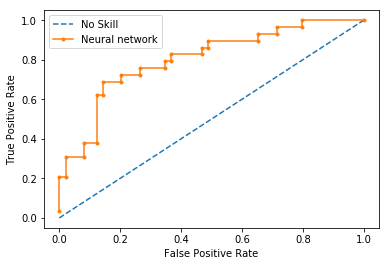

In [8]:
evaluate_model(X_test, torch.from_numpy(np.array(y_test)).float(), nn) # 1e-4, 0.6

#### p = 0.5

In [9]:
nn = DropoutNet(X_train[0].shape, 0.5)
train_model(X_train, torch.from_numpy(np.array(y_train)).float(), nn) 

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


No skill: ROC AUC=0.500
Neural network: ROC AUC=0.750


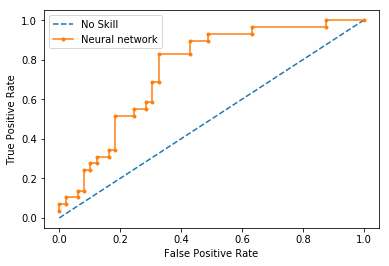

In [10]:
evaluate_model(X_test, torch.from_numpy(np.array(y_test)).float(), nn) # 1e-4, 0.6

#### p = 0.5

In [19]:
nn_ = DropoutNet(X_train[0].shape)
train_model(X_train, torch.from_numpy(np.array(y_train)).float(), nn_) 

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


No skill: ROC AUC=0.500
Neural network: ROC AUC=0.803


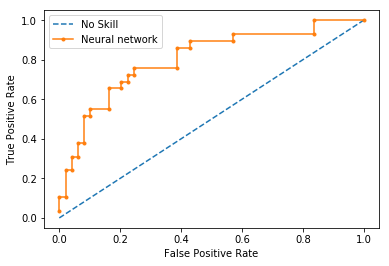

In [20]:
evaluate_model(X_test, torch.from_numpy(np.array(y_test)).float(), nn_) # 1e-4, 0.6

#### p = 0.5, additional fully-connected layer, 5000-->1000-->1

In [ ]:
nn_ = DropoutNet(X_train[0].shape)
train_model(X_train, torch.from_numpy(np.array(y_train)).float(), nn_) 

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [ ]:
evaluate_model(X_test, torch.from_numpy(np.array(y_test)).float(), nn_) # 1e-4, 0.6

### Stratified k-fold cross-validation

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


KeyboardInterrupt: 

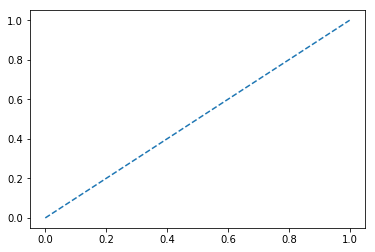

In [14]:
list_aucs = stratifiedKFold(list_inputs, torch.from_numpy(np.array(gr_truth)).float())

### Leave one out cross-validation

In [ ]:
Leave_One_Out(list_inputs, torch.from_numpy(np.array(gr_truth)).float())

## Neural Net

### Train-test split

In [ ]:
my_nn = Net(X_train[0].shape)
train_model(X_train, np.array(y_train), my_nn) 
evaluate_model(X_test, np.array(y_test), my_nn) # 1e-4, 0.6

### Stratified k-fold cross-validation

In [ ]:
list_aucs = stratifiedKFold(list_inputs, torch.from_numpy(np.array(gr_truth)).float())

### Leave one out cross-validation

In [ ]:
Leave_One_Out(list_inputs, torch.from_numpy(np.array(gr_truth)).float())